# Data Analysis

## Setup
### Import libraries

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wordlemodule
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns

### Open data from saved file and create a WordleModule object with it
```wordlemodule.py``` defines a custom class to create and perform calculations on Wordle objects. The data is loaded from the pickle file, and a new wordle object called "data" is created.

In [23]:
# Open pickle file
with open('Data/Script data/Imported_email_data_with_ints.pkl','rb') as file:
    full_data = pickle.load(file)

# Create custom wordle object with input data
data = wordlemodule.WordleData(full_data)

## Plots

### Mean solve score

The first value of interest is the mean solve score per person, where solve score is the number of guesses it took until the puzzle was completely solved (all green in one row). For example, if it only took three guesses to fully guess the word, then the solve score is three.

In the left panel, data is shown as a box plot denoting the interquartile range and median in thin black lines, mean as a thick purple dashed line, and outliers as black-rimmed white circle.

In the right panel, the frequency of each solve score is shown in a histogram. The frequency of unsolved puzzles is shown as well.

C:\Users\Andrés\AppData\Local\Temp\ipykernel_12364\3690710013.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])


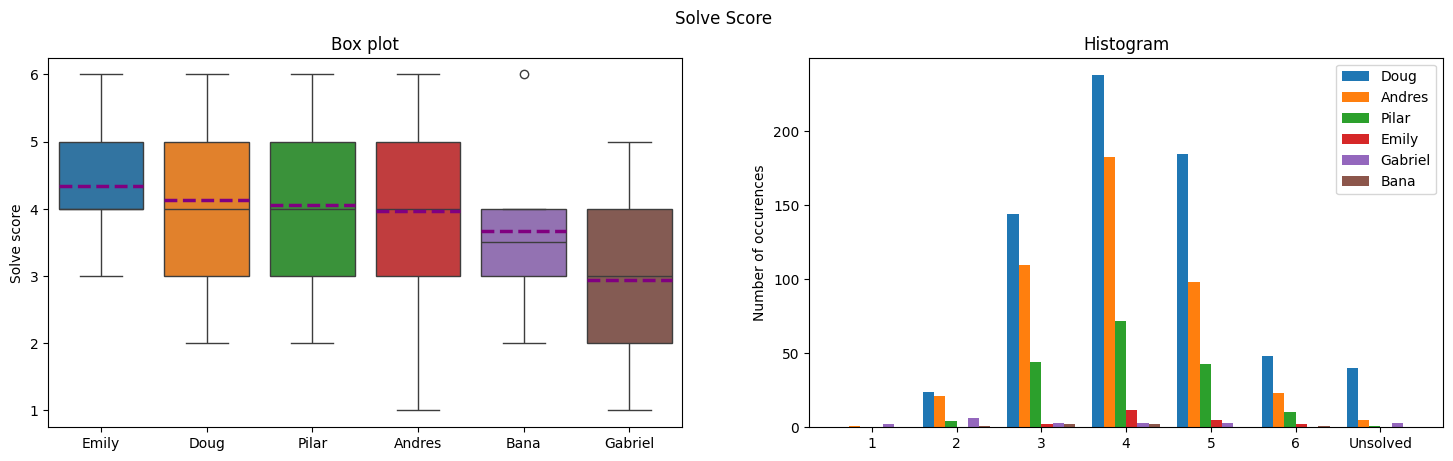

In [ ]:
# Create figure with two subplots
f,ax = plt.subplots(1,2)
f.set_figwidth(18)
f.suptitle('Solve Score')

# Subplot 1: Plot mean solve score
df = data.as_df()
df = df.drop('Puzzle Number',axis=1).replace(7,np.nan)
sorted_cols = df.mean().sort_values(ascending=False)
df_sorted = df[sorted_cols.index]

meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.boxplot(data=df_sorted,
               ax=ax[0],
               showmeans = True,
               meanline = True,
               meanprops = meanlineprops,
               legend='auto')
ax[0].set(ylabel = 'Solve score',
          title = 'Box plot')

# Subplot 2: Plot a histogram of solve score
ax[1].hist(data.data_arr, bins=np.arange(0.5,8.5,1))

ax[1].set_ylabel('Number of occurences')
ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])
ax[1].set_title('Histogram')
ax[1].legend(data.data_dict.keys())

### Solve score over time

-Do people improve over time?

c:\Users\Andrés\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Andrés\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Andrés\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Andrés\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Andrés\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but

<Figure size 640x480 with 0 Axes>

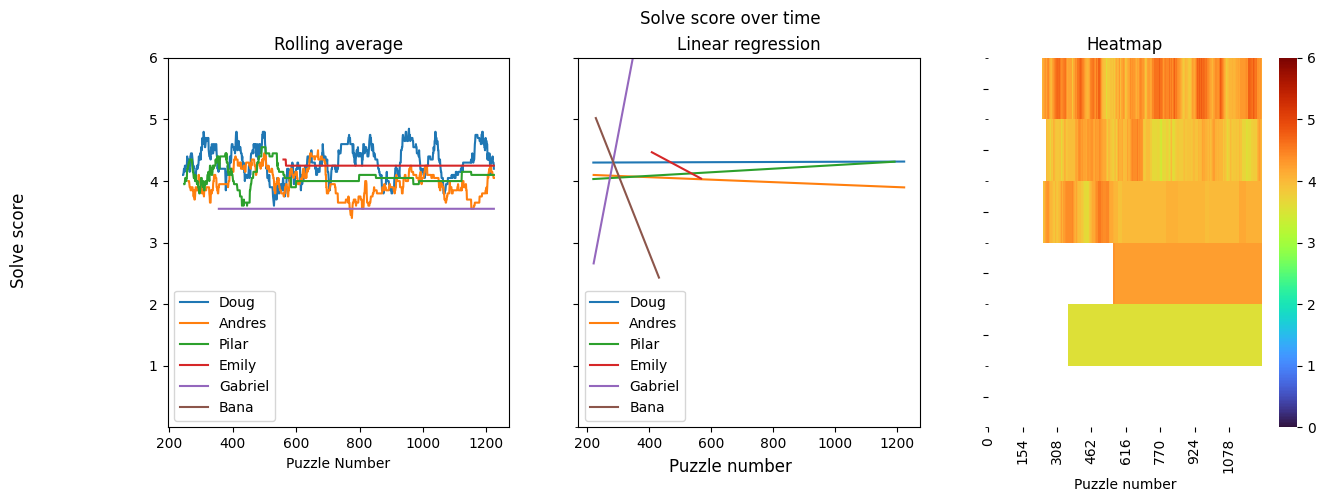

In [6]:
# Set up pandas dataframe with rolling average
df = data.rolling(20)


# Plot scatterplot for solve score over time
score_over_time = plt.figure(2)

myfig, myax = plt.subplots(1,3)
df.plot(title="Rolling average",
               subplots=False,
               ax=myax[0], 
               sharey=True, 
               sharex=True,
               ylim=[0,6], 
               yticks=range(1,7,1),
               xlabel='Puzzle Number')

# Plot linear regression
df_predicted = data.linear_reg()
#df_predicted.drop('Puzzle Number', axis=1,inplace=True)
df_predicted.plot(
    title='Linear regression',
    ax=myax[1],
    ylim=[0,6], 
    yticks=range(1,7,1)
)

# Plot heatmap of correlation
sns.heatmap(df.transpose(),
                 cmap='turbo',
                 vmin=0,
                 vmax=6,
                 ax=myax[2])
myax[2].set(title='Heatmap',
       xlabel='Puzzle number')

#fig.tight_layout()
myfig.suptitle('Solve score over time')
myfig.supylabel('Solve score')
myfig.supxlabel('Puzzle number')
myfig.set_figwidth(15)

### By week-day
Does solve score depened on the day of the week? For example, people may have more time to think about guesses on weekends, and therefore have higher scores on weekends as compared to weekdays.

However, 

[Text(0, 0.5, ''), Text(0.5, 0, '')]

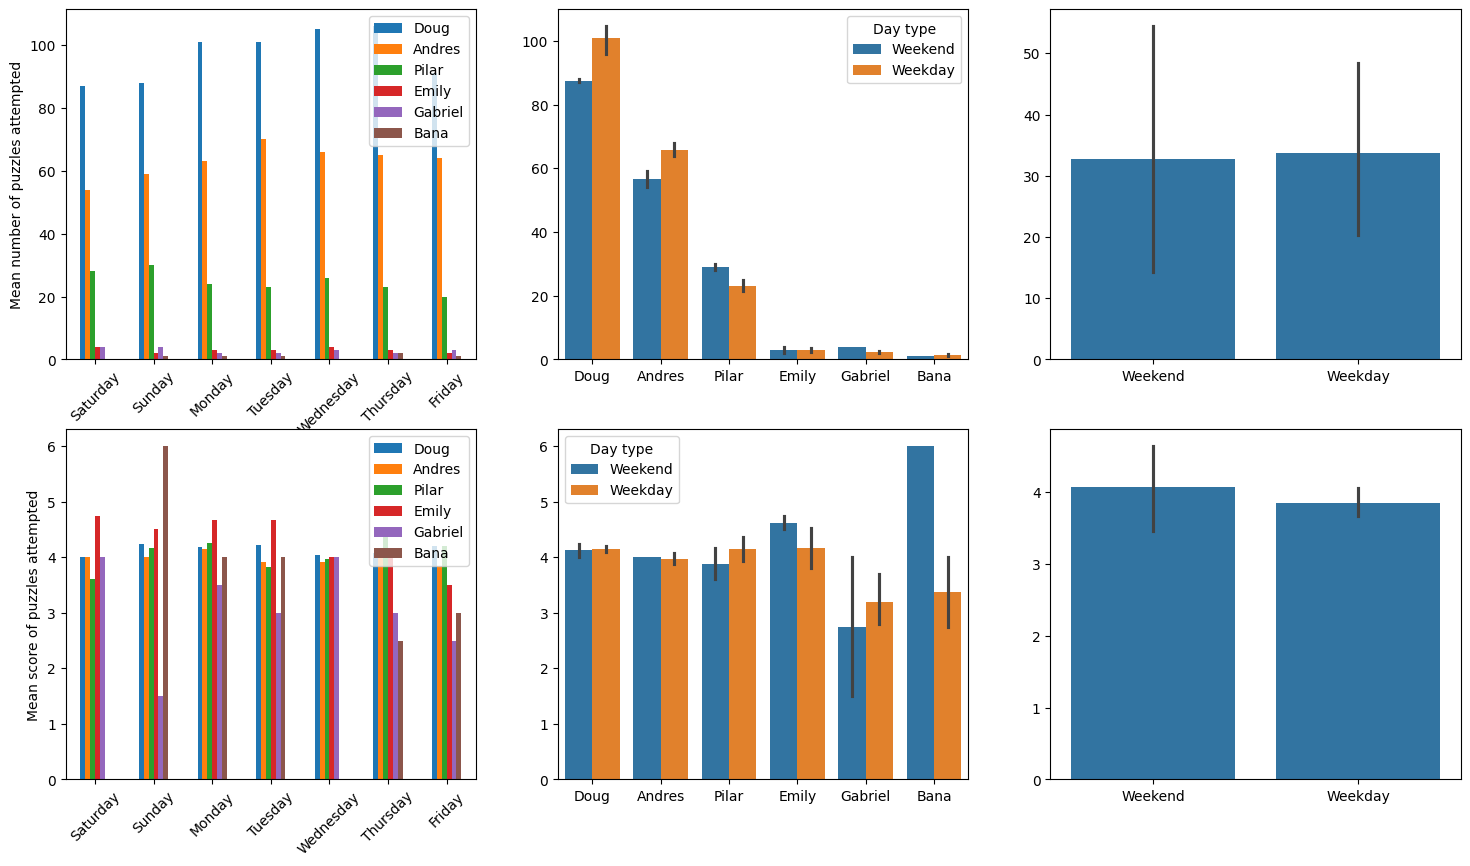

In [6]:
# Use the Wordle object functions to return 
df_weekly_sum, df_weekly_score = data.weekly()

# Create figure and axes for subplots
f, myax = plt.subplots(2, 3)
f.set_figwidth(18)
f.set_figheight(10)
#f.suptitle('Number of puzzles attempted by weekday')

# Subplot column 0: number/score of puzzles attempted
df_weekly_sum.plot.bar(ylabel='Mean number of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[0,0])
df_weekly_score.plot.bar(ylabel='Mean score of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[1,0])

# Add a weekday and weekend variable and change to long-form data
df_weekly_sum['Day type'] = 'Weekday'
df_weekly_score['Day type'] = 'Weekday'
weekends = ['Sunday','Saturday']

df_weekly_sum.loc[weekends,'Day type'] = 'Weekend'
df_weekly_sum_long = pd.melt(df_weekly_sum, id_vars='Day type', var_name='Person', value_name='Value')


df_weekly_score.loc[weekends,'Day type'] = 'Weekend'
df_weekly_score_long = pd.melt(df_weekly_score, id_vars='Day type', var_name='Person', value_name='Value')

# Subplot column 1: number/score of puzzles attempted, by weekend and weekday and by person
sns.barplot(df_weekly_sum_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[0,1])
myax[0,1].set(ylabel = '',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[1,1])
myax[1,1].set(ylabel = '',xlabel='')

# Subplot column 2: number/score of puzzles attempted, by weekend and weekday
sns.barplot(df_weekly_sum_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[0,2])
myax[0,2].set(ylabel = '',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[1,2])
myax[1,2].set(ylabel = '',xlabel='')

### Longest streak (win and no play)

### Scatterplot
- compare score of each game - are same words hard for everyone?
Make regressions for each comparison to see who tracks the best

<Axes: title={'center': 'Correlation between scores'}, xlabel='Comparison', ylabel='Pearson Value'>

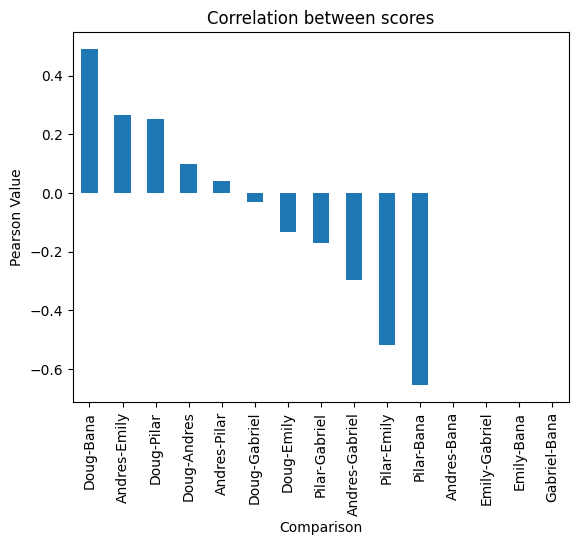

In [ ]:
# Seaborn pairplot of each person's score compared to others
df = pd.DataFrame(data.data_arr, columns=data.data_dict.keys())
g = sns.pairplot(df,kind='reg')

# Calculate Pearson's r-squared and t-test p-values
correlation_matrix = df.corr()

# Create lists of each comparison and pearson value
comparison = []
pearson = []
for col,person_1 in enumerate(correlation_matrix):
    values = correlation_matrix[person_1]
    for row in range(col+1,len(values)):
        person_2 = values.index[row]
        comparison.append(person_1+'-'+person_2)
        pearson.append(values.iloc[row])

# Create dataframe from lists and sort 
corr_list = pd.DataFrame({'Comparison':comparison, 'Pearson Value': pearson})
corr_list = corr_list.sort_values(by=['Pearson Value'], axis=0, ascending=False, na_position='last')

# Plot dataframe
corr_list.plot.bar(x='Comparison',
                   y = 'Pearson Value',
                   legend=False,
                   title='Correlation between scores',
                   ylabel='Pearson Value')


### Which letter slots are easiest to guess? Slot 1?

### What are the most common letter patterns and their guess rates?